In [ ]:
#from google.colab import drive
#drive.mount('/content/drive/')

In [18]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from tqdm import tqdm
import networkx as nx
import scipy
import json
import sys
# sys.path.append('/content/drive/MyDrive/EcolesIngenieur/NTNU/MachineLearning/GroupWork/')
import utils
#import settings
import pickle
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [19]:
def save(nom,model):
  # Enregistrez le modele (ML/scaler/autre) dans un fichier
  with open(nom+'.pkl', 'wb') as f:
      pickle.dump(model, f)

In [20]:
def f_open(chemin):
  with open(chemin, 'rb') as f:
    modele = pickle.load(f)
  return modele

In [21]:
#path = "/content/drive/MyDrive/EcolesIngenieur/NTNU/MachineLearning/GroupWork/"
#train_a, train_b, train_c, X_train_estimated_a, X_train_estimated_b, X_train_estimated_c, X_train_observed_a, X_train_observed_b, X_train_observed_c, X_test_estimated_a, X_test_estimated_b, X_test_estimated_c = utils.read_files(diff_path=path)
train_a = pd.read_parquet('A/train_targets.parquet')
train_b = pd.read_parquet('B/train_targets.parquet')
train_c = pd.read_parquet('C/train_targets.parquet')

X_train_estimated_a = pd.read_parquet('A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('C/X_train_estimated.parquet')

X_train_observed_a = pd.read_parquet('A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('C/X_train_observed.parquet')

X_test_estimated_a = pd.read_parquet('A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('C/X_test_estimated.parquet')

test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')
#test = pd.read_csv(path+"test.csv")
#sample_submission = pd.read_csv(path+"sample_submission.csv")

# Réorganisation des df :

In [22]:
# observed + estimated
X_total_a = pd.concat([X_train_observed_a,X_train_estimated_a])
X_total_b = pd.concat([X_train_observed_b,X_train_estimated_b])
X_total_c = pd.concat([X_train_observed_c,X_train_estimated_c])

Attention, il faut penser à revoir les valeurs météo et pv de estimated !!!

# Changement nom time dans les train

In [23]:
#plt.plot(train_c.isna())

In [24]:
train_a.rename(columns={'time': 'date_forecast'}, inplace=True) #pour faire le merge
train_b.rename(columns={'time': 'date_forecast'}, inplace=True) #pour faire le merge
train_c.rename(columns={'time': 'date_forecast'}, inplace=True) #pour faire le merge
test.rename(columns={'time': 'date_forecast'}, inplace=True)

train_a.dropna(subset=['pv_measurement'], inplace=True)  #Supprime les lignes vides
train_b.dropna(subset=['pv_measurement'], inplace=True)  #Supprime les lignes vides
train_c.dropna(subset=['pv_measurement'], inplace=True)  #Supprime les lignes vides

# Correspondance X et y :

Ici nous avons plusieurs choix :    
- matcher directement sur dateforcast
- matcher sur dateforcast et résumer nos variables météo en moyenne et écart type
- matcher sur un autre créneau (peut être fais sur des variables spécifique !)

Dans un premier temps on fera directement sur dateforcast

In [25]:
X_total_a_y = pd.merge(X_total_a, train_a, on='date_forecast', how='inner')
X_total_b_y = pd.merge(X_total_b, train_b, on='date_forecast', how='inner')
X_total_c_y = pd.merge(X_total_c, train_c, on='date_forecast', how='inner')

# Analyse des Nan

In [26]:
X_train_observed_a['snow_density:kgm3'].isna().sum()/len(X_train_observed_a)

0.9770453951748139

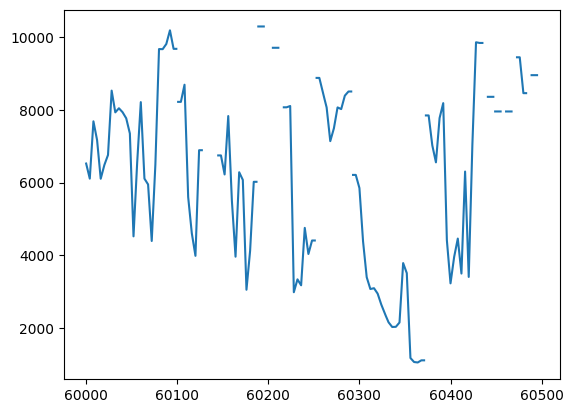

In [27]:
plt.plot(X_train_observed_a['ceiling_height_agl:m'][60000:60500])
#.plot(X_train_observed_a_nan['ceiling_height_agl:m'][60000:60500],ls="--")
#plt.plot(X_train_observed_a['cloud_base_agl:m'][60000:62000].isna())

In [28]:
X_train_observed_a.isna().sum(axis=0)/len(X_train_observed_a)

date_forecast                     0.000000
absolute_humidity_2m:gm3          0.000000
air_density_2m:kgm3               0.000000
ceiling_height_agl:m              0.187471
clear_sky_energy_1h:J             0.000000
clear_sky_rad:W                   0.000000
cloud_base_agl:m                  0.067971
dew_or_rime:idx                   0.000000
dew_point_2m:K                    0.000000
diffuse_rad:W                     0.000000
diffuse_rad_1h:J                  0.000000
direct_rad:W                      0.000000
direct_rad_1h:J                   0.000000
effective_cloud_cover:p           0.000000
elevation:m                       0.000000
fresh_snow_12h:cm                 0.000000
fresh_snow_1h:cm                  0.000000
fresh_snow_24h:cm                 0.000000
fresh_snow_3h:cm                  0.000000
fresh_snow_6h:cm                  0.000000
is_day:idx                        0.000000
is_in_shadow:idx                  0.000000
msl_pressure:hPa                  0.000000
precip_5min

**Conclusion** de l'analyse :    
- Il y a 3 variables avec des Nan
- Snow density est vide à 98% on la supprime
- les deux autres sont vide à 7 et 19% et ce sont des points manquant (problème dans la prise de mesure probablement)
- on décide donc de les compléter par prolongement (moyenne des points environnant)

In [29]:
def gestion_nan(df):
  df_copy = df.copy()
  #delete of the snow density column
  df_copy = df_copy.drop('snow_density:kgm3',axis=1)
  # Approximation of the other two columns
  df_copy['ceiling_height_agl:m'] = df_copy['ceiling_height_agl:m'].interpolate(method='linear', limit_direction='both')
  df_copy['cloud_base_agl:m'] = df_copy['cloud_base_agl:m'].interpolate(method='linear', limit_direction='both')
  return df_copy

In [30]:
X_train_observed_a_nan = gestion_nan(X_train_observed_a)

In [31]:
X_train_observed_a_nan.isna().sum(axis=0)/len(X_train_observed_a_nan)

date_forecast                     0.0
absolute_humidity_2m:gm3          0.0
air_density_2m:kgm3               0.0
ceiling_height_agl:m              0.0
clear_sky_energy_1h:J             0.0
clear_sky_rad:W                   0.0
cloud_base_agl:m                  0.0
dew_or_rime:idx                   0.0
dew_point_2m:K                    0.0
diffuse_rad:W                     0.0
diffuse_rad_1h:J                  0.0
direct_rad:W                      0.0
direct_rad_1h:J                   0.0
effective_cloud_cover:p           0.0
elevation:m                       0.0
fresh_snow_12h:cm                 0.0
fresh_snow_1h:cm                  0.0
fresh_snow_24h:cm                 0.0
fresh_snow_3h:cm                  0.0
fresh_snow_6h:cm                  0.0
is_day:idx                        0.0
is_in_shadow:idx                  0.0
msl_pressure:hPa                  0.0
precip_5min:mm                    0.0
precip_type_5min:idx              0.0
pressure_100m:hPa                 0.0
pressure_50m

# Traitement des df + séparation train/test

## Séparation train/test

A la fin on va projeter à partir de donnée météo estimer sur un periode non rencontré.

On va donc séparer notre train/test sur les même conditions, à savoir que le test sera issue de estimated. Il ne reste qu'à fixer la date à partir de laquelle on fait la séparation.

L'objectif est aussi d'avoir de l'estimated dans l'entrainement pour prendre en compte la différence entre observed et estimated qui devra être régler plus tard.

In [32]:
print(len(X_train_observed_a))
print(len(X_train_estimated_a))
print(len(X_train_estimated_a)/(len(X_train_estimated_a)+len(X_train_observed_a)))

118669
17576
0.12900289918896107


In [33]:
X_total_a_y_nan = gestion_nan(X_total_a_y)
X_total_b_y_nan = gestion_nan(X_total_b_y)
X_total_c_y_nan = gestion_nan(X_total_c_y)

In [34]:
split_date_a = pd.to_datetime("2023-02-01") # on coupe à environ la moitié de estimated

In [35]:
# on coupe nos dataframe à une certaine date
pv_train_a = X_total_a_y_nan[X_total_a_y_nan['date_forecast'] <= split_date_a].copy()
pv_test_a = X_total_a_y_nan[X_total_a_y_nan['date_forecast'] > split_date_a].copy()

pv_train_b = X_total_b_y_nan[X_total_b_y_nan['date_forecast'] <= split_date_a].copy()
pv_test_b = X_total_b_y_nan[X_total_b_y_nan['date_forecast'] > split_date_a].copy()

pv_train_c = X_total_c_y_nan[X_total_c_y_nan['date_forecast'] <= split_date_a].copy()
pv_test_c = X_total_c_y_nan[X_total_c_y_nan['date_forecast'] > split_date_a].copy()

print("train_a :",pv_train_a.shape)
print("test_a :",pv_test_a.shape)
print("Rapport test/total :", round(pv_test_a.shape[0]/(pv_test_a.shape[0]+pv_train_a.shape[0]),3)*100)
print("train_b :",pv_train_b.shape)
print("test_b :",pv_test_b.shape)
print("Rapport test/total :", round(pv_test_b.shape[0]/(pv_test_b.shape[0]+pv_train_b.shape[0]),3)*100)
print("train_c :",pv_train_c.shape)
print("test_c :",pv_test_c.shape)
print("Rapport test/total :", round(pv_test_c.shape[0]/(pv_test_c.shape[0]+pv_train_c.shape[0]),3)*100)

train_a : (31926, 47)
test_a : (2135, 47)
Rapport test/total : 6.3
train_b : (30794, 47)
test_b : (2025, 47)
Rapport test/total : 6.2
train_c : (24518, 47)
test_c : (1553, 47)
Rapport test/total : 6.0


## Changement type de la date_forecast

In [36]:
# on change le type de date_forecast
pv_train_a['date_forecast'] = pd.to_datetime(pv_train_a['date_forecast'])
pv_test_a['date_forecast'] = pd.to_datetime(pv_test_a['date_forecast'])

pv_train_b['date_forecast'] = pd.to_datetime(pv_train_b['date_forecast'])
pv_test_b['date_forecast'] = pd.to_datetime(pv_test_b['date_forecast'])

pv_train_c['date_forecast'] = pd.to_datetime(pv_train_c['date_forecast'])
pv_test_c['date_forecast'] = pd.to_datetime(pv_test_c['date_forecast'])

## Filtrage des variables

In [37]:
pv_train_a.columns

Index(['date_forecast', 'absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
       'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W',
       'cloud_base_agl:m', 'dew_or_rime:idx', 'dew_point_2m:K',
       'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm',
       'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm',
       'fresh_snow_6h:cm', 'is_day:idx', 'is_in_shadow:idx',
       'msl_pressure:hPa', 'precip_5min:mm', 'precip_type_5min:idx',
       'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p',
       'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa',
       'snow_depth:cm', 'snow_drift:idx', 'snow_melt_10min:mm',
       'snow_water:kgm2', 'sun_azimuth:d', 'sun_elevation:d',
       'super_cooled_liquid_water:kgm2', 't_1000hPa:K', 'total_cloud_cover:p',
       'visibility:m', 'wind_speed_10m:ms', 'wind_speed_u_10m:ms',
       'wind_speed_v_10m:ms

In [38]:
#function to apply XGBoost model
def create_features(df, label):

    # V2
    df['hour'] = df["date_forecast"].dt.hour
    df['dayofweek'] = df["date_forecast"].dt.dayofweek
    df['quarter'] = df["date_forecast"].dt.quarter
    df['month'] = df["date_forecast"].dt.month
    df['year'] = df["date_forecast"].dt.year
    df['dayofyear'] = df["date_forecast"].dt.dayofyear
    df['dayofmonth'] = df["date_forecast"].dt.day
    # fin V2
    df = df.drop(["date_calc","date_forecast"],axis=1) # date de calcul des estimated inutil pour l'instant
    if label:
        y = df[label]
        df = df.drop(label,axis=1)
        return df, y
    return df

In [39]:
X_train_a, y_train_a = create_features(pv_train_a, label='pv_measurement')
X_test_a, y_test_a = create_features(pv_test_a, label='pv_measurement')

X_train_b, y_train_b = create_features(pv_train_b, label='pv_measurement')
X_test_b, y_test_b = create_features(pv_test_b, label='pv_measurement')

X_train_c, y_train_c = create_features(pv_train_c, label='pv_measurement')
X_test_c, y_test_c = create_features(pv_test_c, label='pv_measurement')

## Conversion du type de la date

In [40]:
'''
X_train_a[('date_forecast')] = X_train_a[('date_forecast')].values.astype("float64")
X_train_b[('date_forecast')] = X_train_b[('date_forecast')].values.astype("float64")
X_train_c[('date_forecast')] = X_train_c[('date_forecast')].values.astype("float64")
X_test_a[('date_forecast')] = X_test_a[('date_forecast')].values.astype("float64")
X_test_b[('date_forecast')] = X_test_b[('date_forecast')].values.astype("float64")
X_test_c[('date_forecast')] = X_test_c[('date_forecast')].values.astype("float64")
'''

'\nX_train_a[(\'date_forecast\')] = X_train_a[(\'date_forecast\')].values.astype("float64")\nX_train_b[(\'date_forecast\')] = X_train_b[(\'date_forecast\')].values.astype("float64")\nX_train_c[(\'date_forecast\')] = X_train_c[(\'date_forecast\')].values.astype("float64")\nX_test_a[(\'date_forecast\')] = X_test_a[(\'date_forecast\')].values.astype("float64")\nX_test_b[(\'date_forecast\')] = X_test_b[(\'date_forecast\')].values.astype("float64")\nX_test_c[(\'date_forecast\')] = X_test_c[(\'date_forecast\')].values.astype("float64")\n'

## Normalisation

In [41]:
def sklearn_z_score_normalize_dataframe(df,return_scaler=False,scaler=None):
    """
    Normalizes a DataFrame using z-score normalization (mean and standard deviation) from Scikit-Learn.

    Parameters:
    df (pd.DataFrame): The DataFrame to be normalized.

    Returns:
    pd.DataFrame: The z-score normalized DataFrame.
    """
    if scaler == None :
      # Create a StandardScaler instance
      scaler = StandardScaler()

      # Fit the scaler on the DataFrame and transform the data
      normalized_data = scaler.fit_transform(df)

    else : normalized_data = scaler.transform(df)

    # Create a new DataFrame with the scaled data
    normalized_df = pd.DataFrame(normalized_data, columns=df.columns)

    # retourner le scaler
    if return_scaler :
      return normalized_df,scaler
    return normalized_df

In [42]:
X_train_a_norm,scaler_a = sklearn_z_score_normalize_dataframe(X_train_a,return_scaler=True)
X_train_b_norm,scaler_b = sklearn_z_score_normalize_dataframe(X_train_b,return_scaler=True)
X_train_c_norm,scaler_c = sklearn_z_score_normalize_dataframe(X_train_c,return_scaler=True)

In [43]:
X_test_a_norm = sklearn_z_score_normalize_dataframe(X_test_a,return_scaler=False,scaler=scaler_a)
X_test_b_norm = sklearn_z_score_normalize_dataframe(X_test_b,return_scaler=False,scaler=scaler_b)
X_test_c_norm = sklearn_z_score_normalize_dataframe(X_test_c,return_scaler=False,scaler=scaler_c)

## Preprocessing globale

faire un code qui reprend toute les étapes ci dessus pour éviter de faire plein de lignes qui  se répêtes !!!

# Partie XBGoost de base (Nahel)

In [44]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [45]:
##########################################################################################################################

In [46]:
# Créez un modèle XGBoost
# Hyperparameters : n_estimators, booster, max_depth, min_child_weight, gamma, eta
reg_a = xgb.XGBRegressor(n_estimators =  10000,
                         max_depth = 8,
                         eval_metric = 'mae',
                        )

reg_a.fit(X_train_a_norm, y_train_a,
          eval_set=[(X_train_a_norm, y_train_a), (X_test_a_norm, y_test_a)],
          early_stopping_rounds=50,
          verbose=True)

reg_b = xgb.XGBRegressor(n_estimators =  10000,
                         max_depth =  3,
                         eval_metric = 'mae',
                        )

reg_b.fit(X_train_b_norm, y_train_b,
          eval_set=[(X_train_b_norm, y_train_b), (X_test_b_norm, y_test_b)],
          early_stopping_rounds=50,
          verbose=True)

reg_c = xgb.XGBRegressor(n_estimators =  10000,
                         max_depth =  4,
                         eval_metric = 'mae',
                        )
                         
                         

reg_c.fit(X_train_c_norm, y_train_c,
          eval_set=[(X_train_c_norm, y_train_c), (X_test_c_norm, y_test_c)],
          early_stopping_rounds=50,
          verbose=True)


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-mae:610.31083	validation_1-mae:619.61146
[1]	validation_0-mae:463.02493	validation_1-mae:489.22271
[2]	validation_0-mae:365.23828	validation_1-mae:401.01004
[3]	validation_0-mae:298.35621	validation_1-mae:341.00324
[4]	validation_0-mae:251.83989	validation_1-mae:295.60327
[5]	validation_0-mae:219.31334	validation_1-mae:264.66728
[6]	validation_0-mae:195.37221	validation_1-mae:240.46794
[7]	validation_0-mae:177.70700	validation_1-mae:225.84429
[8]	validation_0-mae:165.17733	validation_1-mae:214.85519
[9]	validation_0-mae:155.58875	validation_1-mae:209.73057
[10]	validation_0-mae:147.19907	validation_1-mae:207.76158
[11]	validation_0-mae:140.83755	validation_1-mae:206.01122
[12]	validation_0-mae:136.12035	validation_1-mae:203.65314
[13]	validation_0-mae:131.68443	validation_1-mae:202.34890
[14]	validation_0-mae:127.12248	validation_1-mae:202.19190
[15]	validation_0-mae:124.35957	validation_1-mae:202.18901
[16]	validation_0-mae:122.85242	validation_1-mae:202.33435
[17]	va

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-mae:101.80114	validation_1-mae:98.58015
[1]	validation_0-mae:83.89930	validation_1-mae:81.16933
[2]	validation_0-mae:71.80079	validation_1-mae:69.43749
[3]	validation_0-mae:63.51134	validation_1-mae:59.16342
[4]	validation_0-mae:57.84604	validation_1-mae:54.15839
[5]	validation_0-mae:54.22236	validation_1-mae:49.08535
[6]	validation_0-mae:51.41784	validation_1-mae:46.22251
[7]	validation_0-mae:49.23349	validation_1-mae:45.17655
[8]	validation_0-mae:47.95382	validation_1-mae:43.84863
[9]	validation_0-mae:46.65096	validation_1-mae:44.25610
[10]	validation_0-mae:45.62755	validation_1-mae:43.52948
[11]	validation_0-mae:45.00218	validation_1-mae:43.25464
[12]	validation_0-mae:44.45856	validation_1-mae:42.55676
[13]	validation_0-mae:44.05321	validation_1-mae:41.84375
[14]	validation_0-mae:44.05509	validation_1-mae:41.94394
[15]	validation_0-mae:43.60595	validation_1-mae:42.05915
[16]	validation_0-mae:43.35850	validation_1-mae:41.34797
[17]	validation_0-mae:43.37590	validatio

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-mae:81.67695	validation_1-mae:71.21537
[1]	validation_0-mae:62.02939	validation_1-mae:56.43304
[2]	validation_0-mae:49.08622	validation_1-mae:47.54777
[3]	validation_0-mae:40.44353	validation_1-mae:40.76681
[4]	validation_0-mae:34.58776	validation_1-mae:37.02277
[5]	validation_0-mae:30.67857	validation_1-mae:35.78658


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-mae:28.04236	validation_1-mae:35.22966
[7]	validation_0-mae:26.18881	validation_1-mae:33.40443
[8]	validation_0-mae:24.89496	validation_1-mae:32.78817
[9]	validation_0-mae:24.07624	validation_1-mae:33.00203
[10]	validation_0-mae:23.46462	validation_1-mae:32.89150
[11]	validation_0-mae:23.07864	validation_1-mae:32.18814
[12]	validation_0-mae:22.68417	validation_1-mae:32.01737
[13]	validation_0-mae:22.16450	validation_1-mae:32.25863
[14]	validation_0-mae:22.03599	validation_1-mae:32.22436
[15]	validation_0-mae:21.81681	validation_1-mae:32.79298
[16]	validation_0-mae:21.87498	validation_1-mae:32.92495
[17]	validation_0-mae:21.72667	validation_1-mae:33.37238
[18]	validation_0-mae:21.63554	validation_1-mae:33.48070
[19]	validation_0-mae:21.51669	validation_1-mae:33.29342
[20]	validation_0-mae:21.31431	validation_1-mae:33.39332
[21]	validation_0-mae:21.18400	validation_1-mae:33.15229
[22]	validation_0-mae:21.07036	validation_1-mae:32.98759
[23]	validation_0-mae:20.95863	vali

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='mae', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

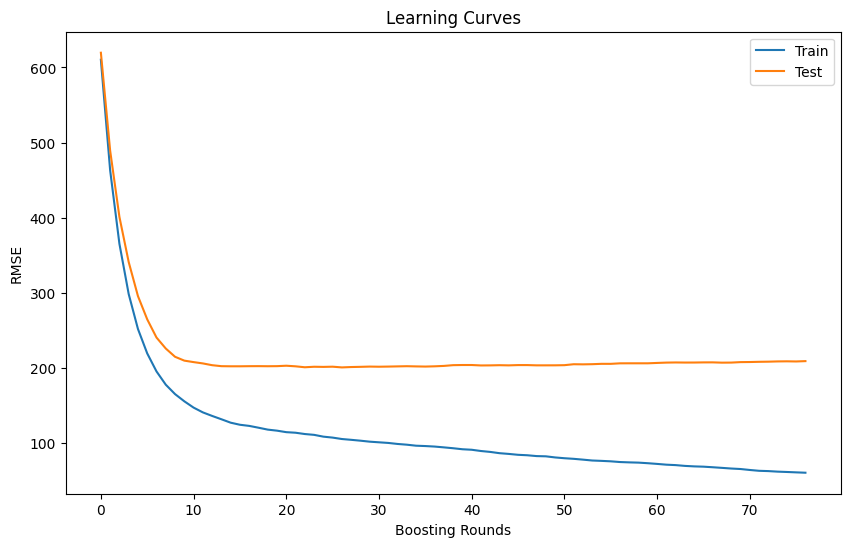

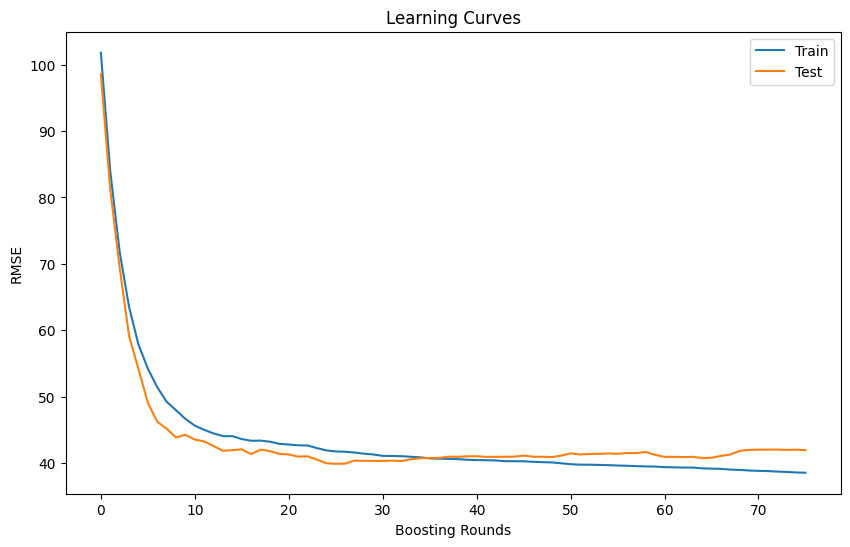

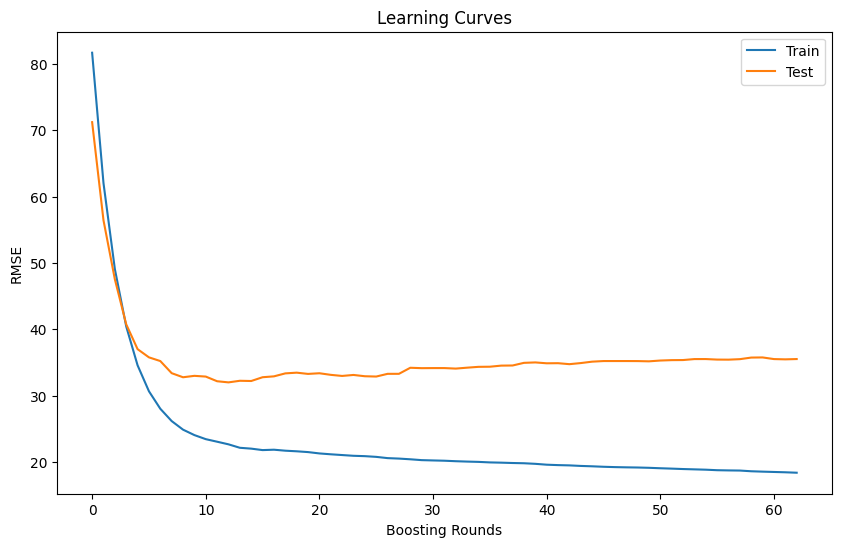

In [47]:
# Créez des listes vides pour stocker les erreurs d'entraînement et de test
train_errors = []
test_errors = []

# Accédez aux erreurs d'entraînement et de test après chaque itération
results = reg_a.evals_result()
train_errors = results['validation_0']['mae']
test_errors = results['validation_1']['mae']

# Tracez les courbes d'apprentissage
plt.figure(figsize=(10, 6))
plt.plot(train_errors, label='Train')
plt.plot(test_errors, label='Test')
plt.xlabel('Boosting Rounds')
plt.ylabel('RMSE')
plt.legend()
plt.title('Learning Curves')
plt.show()

# Créez des listes vides pour stocker les erreurs d'entraînement et de test
train_errors = []
test_errors = []

# Accédez aux erreurs d'entraînement et de test après chaque itération
results = reg_b.evals_result()
train_errors = results['validation_0']['mae']
test_errors = results['validation_1']['mae']

# Tracez les courbes d'apprentissage
plt.figure(figsize=(10, 6))
plt.plot(train_errors, label='Train')
plt.plot(test_errors, label='Test')
plt.xlabel('Boosting Rounds')
plt.ylabel('RMSE')
plt.legend()
plt.title('Learning Curves')
plt.show()

# Créez des listes vides pour stocker les erreurs d'entraînement et de test
train_errors = []
test_errors = []

# Accédez aux erreurs d'entraînement et de test après chaque itération
results = reg_c.evals_result()
train_errors = results['validation_0']['mae']
test_errors = results['validation_1']['mae']

# Tracez les courbes d'apprentissage
plt.figure(figsize=(10, 6))
plt.plot(train_errors, label='Train')
plt.plot(test_errors, label='Test')
plt.xlabel('Boosting Rounds')
plt.ylabel('RMSE')
plt.legend()
plt.title('Learning Curves')
plt.show()

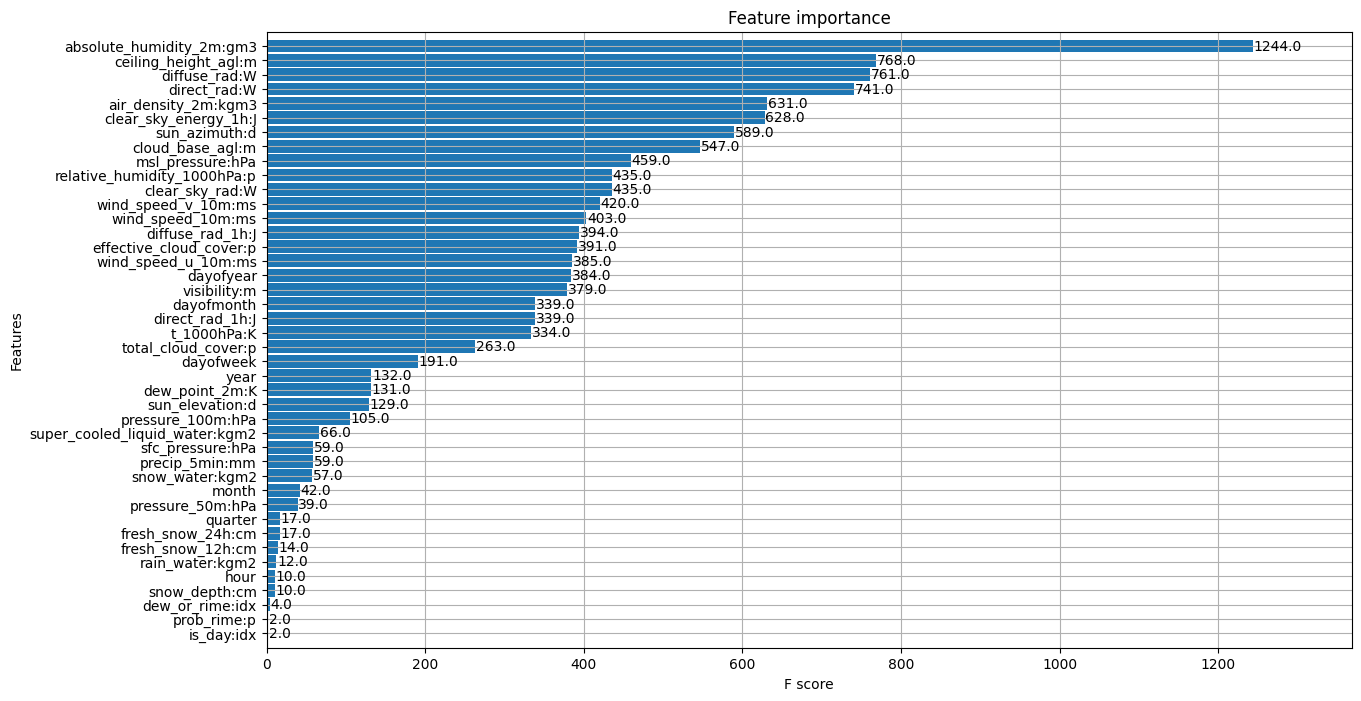

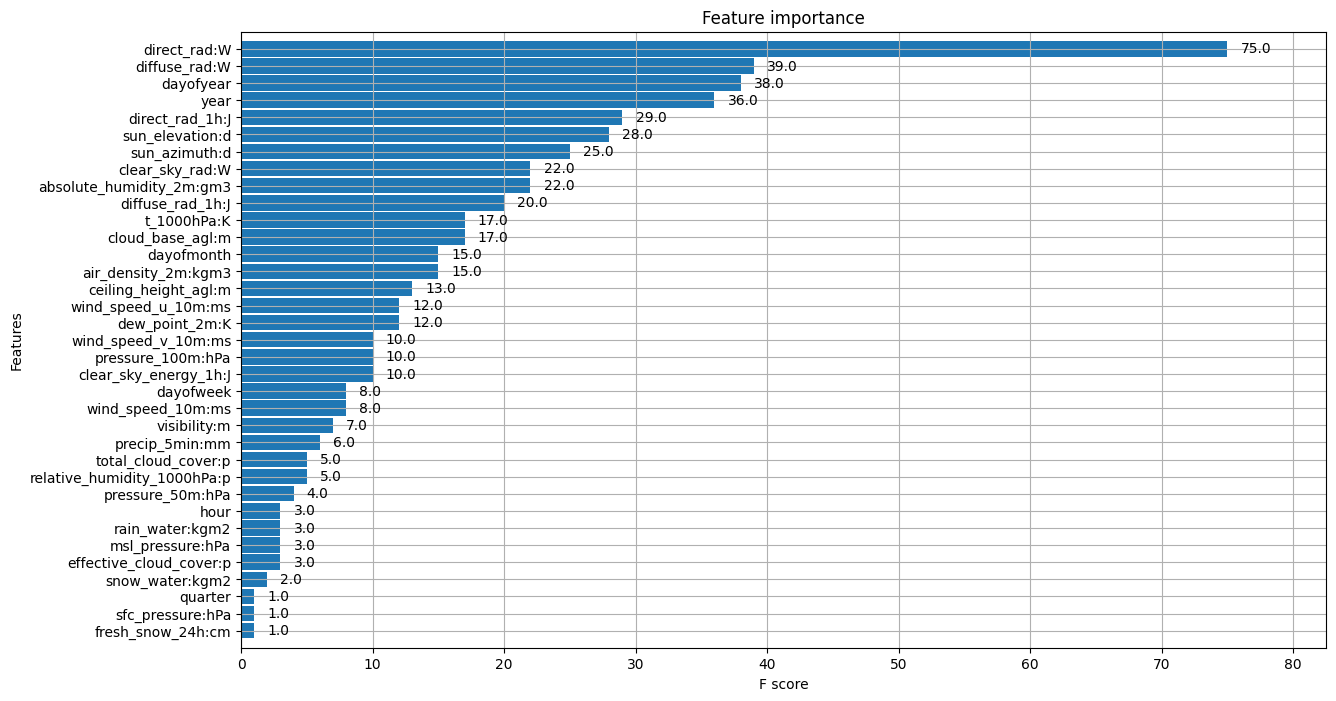

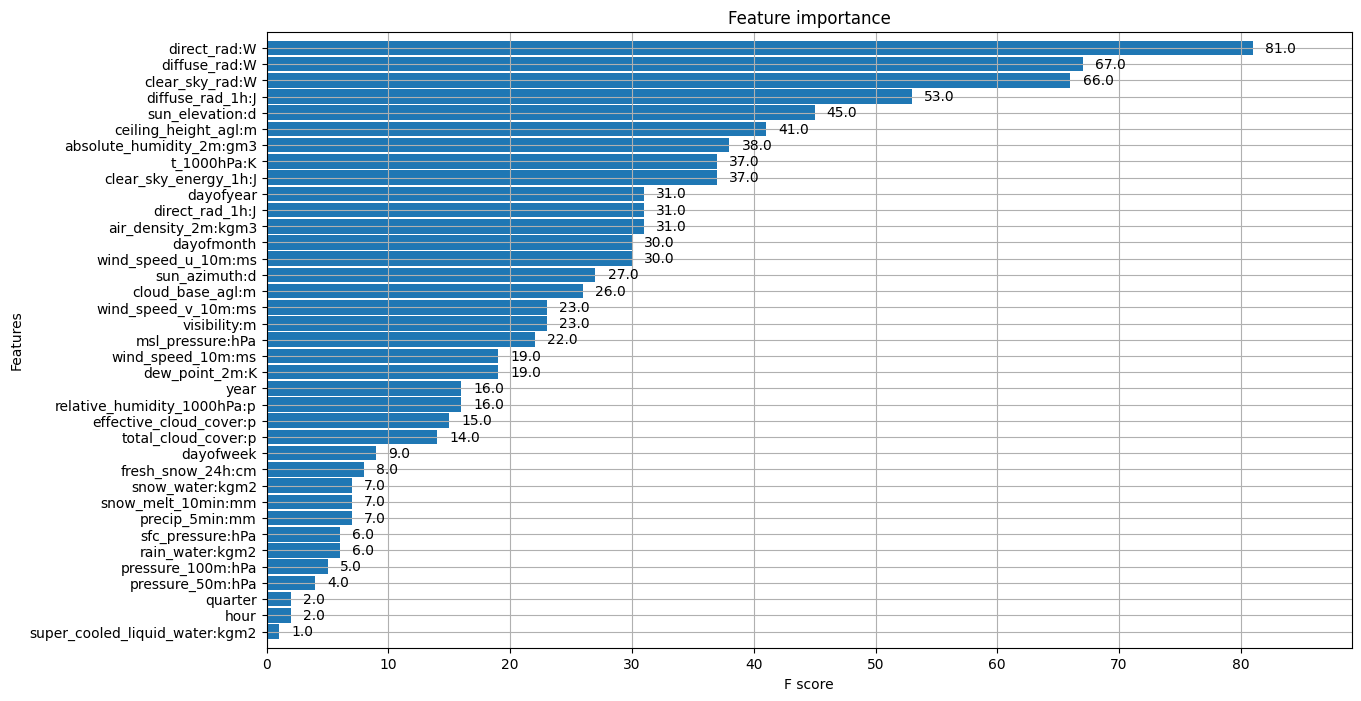

In [48]:
_ = plot_importance(reg_a, height=0.9)
plt.gcf().set_size_inches(14,8)
_ = plot_importance(reg_b, height=0.9)
plt.gcf().set_size_inches(14,8)
_ = plot_importance(reg_c, height=0.9)
plt.gcf().set_size_inches(14,8)

In [49]:
###############################
# Observation du 05/11/2023 sur A: 
# changement sur l'importance des variables 
##############################

In [50]:
'''
reg_a = xgb.XGBRegressor(n_estimators=10000,
                         max_depth = 6,
                         eval_metric = 'mae',
                        )

reg_a.fit(X_train_a_norm, y_train_a,
          eval_set=[(X_train_a_norm, y_train_a), (X_test_a_norm, y_test_a)],
          early_stopping_rounds=50,
          verbose=True)

_ = plot_importance(reg_a, height=0.9)
plt.gcf().set_size_inches(14,8)
'''

"\nreg_a = xgb.XGBRegressor(n_estimators=10000,\n                         max_depth = 6,\n                         eval_metric = 'mae',\n                        )\n\nreg_a.fit(X_train_a_norm, y_train_a,\n          eval_set=[(X_train_a_norm, y_train_a), (X_test_a_norm, y_test_a)],\n          early_stopping_rounds=50,\n          verbose=True)\n\n_ = plot_importance(reg_a, height=0.9)\nplt.gcf().set_size_inches(14,8)\n"

In [51]:
'''
reg_a = xgb.XGBRegressor(n_estimators=10000,
                         max_depth = 4,
                         eval_metric = 'mae',
                        )

reg_a.fit(X_train_a_norm, y_train_a,
          eval_set=[(X_train_a_norm, y_train_a), (X_test_a_norm, y_test_a)],
          early_stopping_rounds=50,
          verbose=True)

_ = plot_importance(reg_a, height=0.9)
plt.gcf().set_size_inches(14,8)
'''

"\nreg_a = xgb.XGBRegressor(n_estimators=10000,\n                         max_depth = 4,\n                         eval_metric = 'mae',\n                        )\n\nreg_a.fit(X_train_a_norm, y_train_a,\n          eval_set=[(X_train_a_norm, y_train_a), (X_test_a_norm, y_test_a)],\n          early_stopping_rounds=50,\n          verbose=True)\n\n_ = plot_importance(reg_a, height=0.9)\nplt.gcf().set_size_inches(14,8)\n"

In [52]:
pv_test_a['pv_measurement_prediction'] = reg_a.predict(X_test_a_norm)
pv_all_a = pd.concat([pv_test_a, pv_train_a], sort=False)

pv_test_b['pv_measurement_prediction'] = reg_b.predict(X_test_b_norm)
pv_all_b = pd.concat([pv_test_b, pv_train_b], sort=False)

pv_test_c['pv_measurement_prediction'] = reg_c.predict(X_test_c_norm)
pv_all_c = pd.concat([pv_test_c, pv_train_c], sort=False)

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

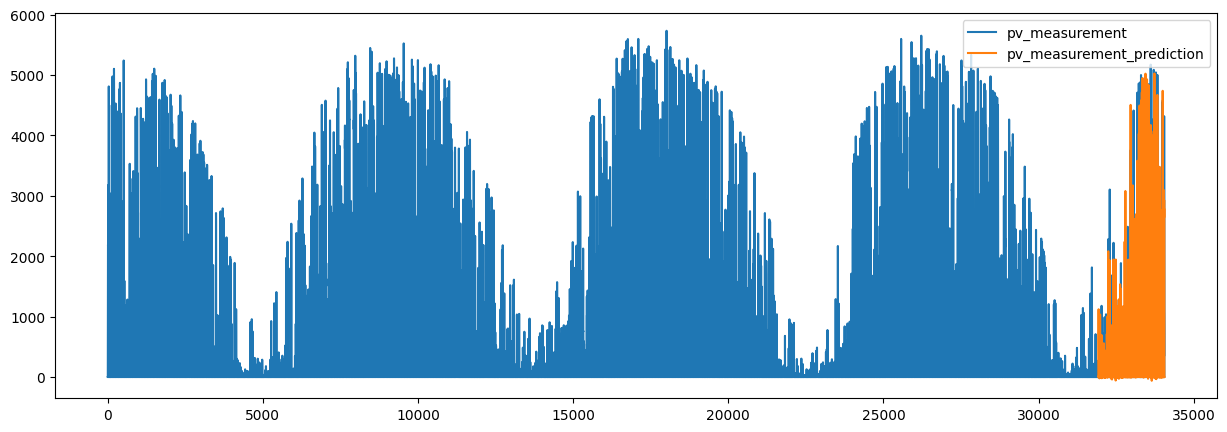

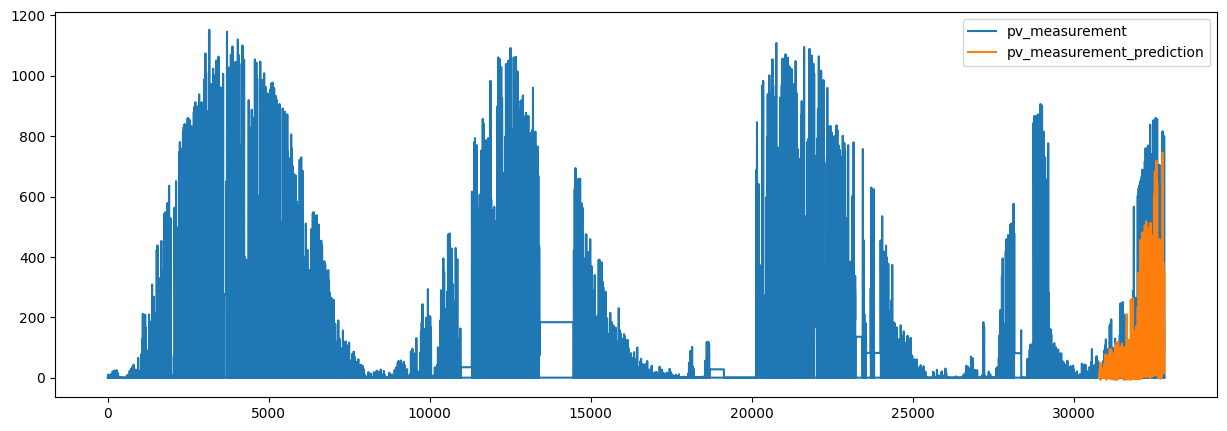

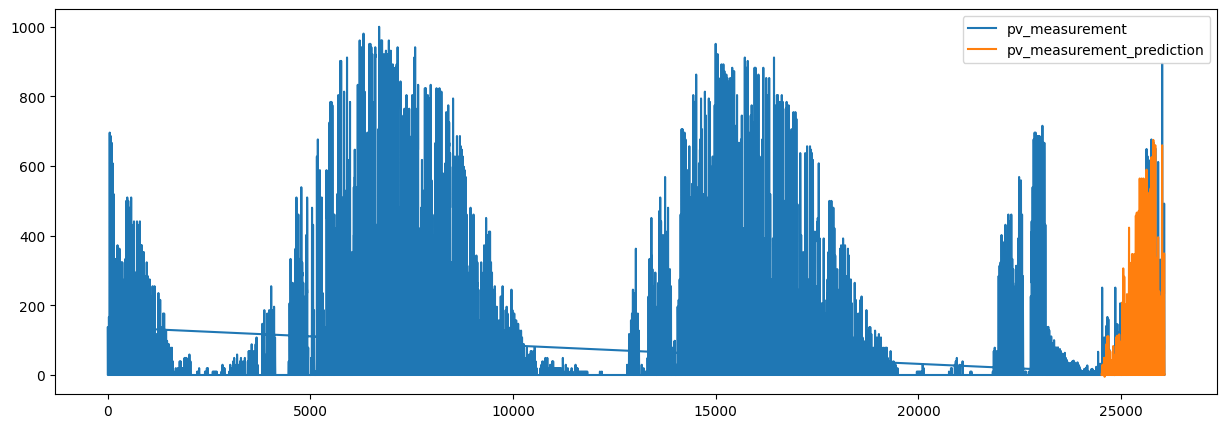

In [53]:
graph = pv_all_a[['pv_measurement','pv_measurement_prediction']].plot(figsize=(15, 5))
graph = pv_all_b[['pv_measurement','pv_measurement_prediction']].plot(figsize=(15, 5))
graph = pv_all_c[['pv_measurement','pv_measurement_prediction']].plot(figsize=(15, 5))

# Export sur Kaggle

In [54]:
test = pd.read_csv("test.csv")
test_copy = test.copy()
test.rename(columns={'time': 'date_forecast'}, inplace=True) #pour faire le merge
test["date_forecast"] = pd.to_datetime(test["date_forecast"]) #mettre le bon type

In [55]:
# Lecture des données météo associée :
merged_df_pre_a = pd.merge(X_test_estimated_a, test, on='date_forecast', how='inner')
merged_df_a = merged_df_pre_a[merged_df_pre_a["location"]=="A"]
merged_df_pre_b = pd.merge(X_test_estimated_b, test, on='date_forecast', how='inner')
merged_df_b = merged_df_pre_b[merged_df_pre_b["location"]=="B"]
merged_df_pre_c = pd.merge(X_test_estimated_c, test, on='date_forecast', how='inner')
merged_df_c = merged_df_pre_c[merged_df_pre_c["location"]=="C"]

In [56]:
def preprocessing_test(df,scaler):
  X_test = df.drop(["id","location","prediction"],axis=1)
  X_test = create_features(X_test,None)
  #X_test[('date_forecast')] = X_test[('date_forecast')].values.astype("float64")
  X_test = gestion_nan(X_test)
  X_test = sklearn_z_score_normalize_dataframe(X_test,return_scaler=False,scaler=scaler)
  return X_test

In [57]:
X_test_a_test = preprocessing_test(merged_df_a,scaler_a)
X_test_b_test = preprocessing_test(merged_df_b,scaler_b)
X_test_c_test = preprocessing_test(merged_df_c,scaler_c)

In [58]:
result_A = reg_a.predict(X_test_a_test)
result_B = reg_b.predict(X_test_b_test)
result_C = reg_c.predict(X_test_c_test)

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

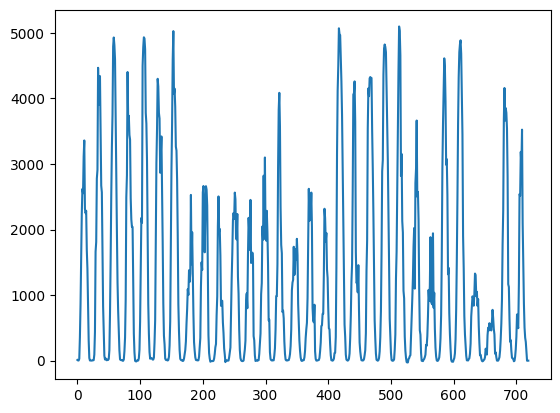

In [59]:
plt.plot(result_A)

In [86]:
nom_fichier = 'XGBoost_pre_Nahel'
repertoire = r'C:\Users\verdi\OneDrive\Bureau\NTNU\Machine learning\Project\data\data\hyperparamètre\A'
result = np.concatenate((np.concatenate((result_A,result_B)), result_C))
test_copy['prediction'] = result
sample_submission = sample_submission[['id']].merge(test_copy[['id', 'prediction']], on='id', how='left')
sample_submission.to_csv(repertoire+ nom_fichier+'.csv', index=False)

Prochaines amélioration

- mettre un minimum *Done*
- suppression des zones continues en B et C *To DO*
- prise en compte de la date (jour/mois/heure) *Done* peut être ajusté ?
- prendre le meilleur model : celui avec le meilleur score sur le deuxième testset (A : 2,8% B : 5,5%  C: 11,5%) (score eval prévu : 166) --> déjà pris en copmte dans la fonction ...


Perf V1:

A : Test 2 : 446 / 459

B : Test 2 : 101 / 107

C : Test 2 : 68 / 78

Perf V2:

A : Test 1 : 243 | Test 2 : 438 / 455

B : Test 1 : 35 | Test 2 : 106 / 110

C : Test 1 : 26 | Test 2 : 65 / 71

# Post traitement

Ici, on va faire en sorte de n'avoir que des valeurs positives (cela ne représente qu'une légère amélioration

In [87]:
result = np.concatenate((np.concatenate((result_A,result_B)), result_C))

In [88]:
negative_values = result[result < 0]
sum_of_negatives = np.sum(negative_values)/len(result)
print(sum_of_negatives)

-0.15431415416576244


In [89]:
negative_mask = result < 0
result[negative_mask] = 0

In [90]:
nom_fichier = 'XGB_post_Nahel'
repertoire = r'C:\Users\verdi\OneDrive\Bureau\NTNU\Machine learning\Project\data\data\hyperparamètre\A'
test_copy['prediction'] = result
sample_submission = sample_submission[['id']].merge(test_copy[['id', 'prediction']], on='id', how='left')
sample_submission.to_csv(repertoire+ nom_fichier+'.csv', index=False)

**Liste amélioration V2** :

Data preprocessing :
- Gestion zones continues B et C (suppression ou autre solution)
- Gestion merge entre data météo et pv

Model :
- régler les hyperparamètres

Post process